In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import spyrit.core.torch as st
from scipy.linalg import hadamard

In [2]:
def rht(X, Y, signs=None):
    if signs is None:
        signs = np.random.choice([-1, 1], size=X.shape[0])
    D = np.diag(signs)
    result_X = np.dot(D, X)
    result_Y = np.dot(D, Y)

    tensor_matrix_X = torch.tensor(result_X)
    tensor_matrix_Y = torch.tensor(result_Y)

    # Use natural (Kronecker) order: order=False
    tensor_matrix_X = st.fwht(tensor_matrix_X.T, order=False).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y.T, order=False).T

    X_out = tensor_matrix_X.numpy() / np.sqrt(X.shape[0])
    Y_out = tensor_matrix_Y.numpy() / np.sqrt(Y.shape[0])
    return X_out, Y_out, signs

In [3]:
def algorithm_for_BHDdot(n,k,p,weight,mu_1,mu_2,var_1,var_2,proportion,random_seed=39):
    m = int(n/k)
    ## 2: Generate our GMM raw data, this (i) is not considered as the part of this scheme algorithm.
    mu_1_vector = np.ones(p) * mu_1
    sigma_1_vector = np.eye(p) * var_1
    mu_2_vector = np.ones(p) * mu_2
    sigma_2_vector = np.eye(p) * var_2
    weight_1 = weight
    data_proportion_1_no_rows = int(n * weight_1)
    data_proportion_2_no_rows = n - data_proportion_1_no_rows
    np.random.seed(random_seed)
    data_1 = np.random.multivariate_normal(mu_1_vector, sigma_1_vector,size=data_proportion_1_no_rows)
    data_2 = np.random.multivariate_normal(mu_2_vector, sigma_2_vector,size=data_proportion_2_no_rows)
    X_raw = np.vstack((data_1, data_2))
    np.random.shuffle(X_raw)
    epsilon = np.random.normal(0,1,size = n)
    beta = np.random.normal(0,1,size = p)
    Y_raw = np.dot(X_raw,beta) + epsilon
    ## 3a: Partition the data equally to k clients.
    X_clients = np.array_split(X_raw, k)
    Y_clients = np.array_split(Y_raw, k)
    ## 3b: draw global Rademacher signs once
    np.random.seed(random_seed)
    global_signs = np.random.choice([-1, 1], size=n)
    ## 4: Apply normalized rht on each client side
    X_rht_clients = []
    Y_rht_clients = []
    for i in range(k):
      start = i * m
      end   = (i+1) * m
      signs_i = global_signs[start:end]
      X_rht, Y_rht, _ = rht(X_clients[i], Y_clients[i].reshape(-1, 1), signs=signs_i)
      X_rht_clients.append(X_rht)
      Y_rht_clients.append(Y_rht)
    ## 5a: Generate a randomized np.index list, the length is 'proportion' * m for each client (but fixed for all of them_meaning the same indices are used for all clients), index range is from 0 to m-1 (inclusive).
    np.random.seed(random_seed)
    selected_indices = np.random.choice(m, size=int(proportion * m), replace=False)
    ## 5b: make this index list to a diagonal matrix, with 1 on the selected indices and 0 elsewhere, so the dimension should be m x m.
    S_matrix = np.zeros((m, m))
    for index in selected_indices:
        S_matrix[index, index] = 1
    ## 6: Use this index matrix S to do on each client: S*H_m*D_i*X_i and S*H_m*D_i*Y_i (this process could be done either by using 5a or 5b, choose one which is faster).
    X_final_clients = []
    Y_final_clients = []
    for i in range(k):
        X_final = np.dot(S_matrix, X_rht_clients[i])
        Y_final = np.dot(S_matrix, Y_rht_clients[i])
        X_final_clients.append(X_final)
        Y_final_clients.append(Y_final)
    ## 7a: concatenate all the clients' final X and Y by columns to recover the dimension of (proportion*n) x p for X and (proportion*n) x 1 for Y.
    X_final_all = np.vstack(X_final_clients)
    Y_final_all = np.vstack(Y_final_clients)
    ## 7b: Compute the kronecker product: H_k ⊗ I_m first (H_k is the normalized hadamard matrix with dimension k xk, I_m is the identity matrix with dimension m x m), then multiply it with the concatenated X and Y from 7a.
    H_k = hadamard(k) / np.sqrt(k)
    I_m = np.eye(m)
    H_k_kron_I_m = np.kron(H_k, I_m)
    X_global = np.dot(H_k_kron_I_m, X_final_all)
    Y_global = np.dot(H_k_kron_I_m, Y_final_all)
    ### 7c: Eliminate the zero rows inside X_global and Y_global to get the final output
    non_zero_row_indices = []
    for i in range(X_global.shape[0]):
        if not np.all(X_global[i, :] == 0):
            non_zero_row_indices.append(i)
    X_global = X_global[non_zero_row_indices, :]
    Y_global = Y_global[non_zero_row_indices, :]
    ## Directly do sampling on the raw matrix
    selected_indices_global = np.random.choice(n, size=int(proportion * n), replace=False)
    X_raw = X_raw[selected_indices_global, :]
    Y_raw = Y_raw[selected_indices_global].reshape(-1, 1)
    return X_global, Y_global, X_raw, Y_raw, beta

In [4]:
def partition_matrix_not_necessary_divisable(X,Y,k):
    """
    Partition the rows of matrix X across k machines uniformly with equal probability.
    Each machine will receive a sub-matrix of X and the corresponding sub-vector of Y.

    Parameters:
    X (numpy.ndarray): The input matrix to be partitioned (n rows, m columns).
    Y (numpy.ndarray): The output vector to be partitioned (n rows, 1 column).
    k (int): The number of machines.

    Returns:
    list of numpy.ndarray: A list of sub-matrices, each assigned to a machine.
    """
    # Get the number of rows in the matrix
    n = X.shape[0]
    
    # Create an array of row indices (0 to n-1)
    indices = np.arange(n)
    
    # Shuffle the indices randomly to ensure each row has equal probability
    np.random.shuffle(indices)
    
    # Calculate the base size of each partition and the remainder
    part_size = n // k  # Base number of rows per machine
    remainder = n % k   # Extra rows to distribute
    
    # Split the indices into k parts
    parts = []
    start = 0
    for i in range(k):
        # The first 'remainder' machines get one extra row
        end = start + part_size + (1 if i < remainder else 0)
        parts.append(indices[start:end])
        start = end
    
    # Create sub-matrices for each machine using the partitioned indices
    sub_matrices = [X[part] for part in parts]
    sub_matrices_Y = [Y[part] for part in parts]
    
    return sub_matrices, sub_matrices_Y

In [5]:
def average_regression_train_not_divisable(X, Y, k):
    """
    Distributed OLS with uniform random partition into k machines (not necessarily divisible).
    Uses your partition_matrix_not_necessary_divisable.
    Returns the averaged beta across machines.
    """
    sub_matrices, sub_target = partition_matrix_not_necessary_divisable(X, Y, k)
    beta_list = []

    for X_i, Y_i in zip(sub_matrices, sub_target):
        X_i = np.asarray(X_i)
        Y_i = np.asarray(Y_i).reshape(-1)
        # local OLS (no regularization)
        beta_i = np.linalg.inv(X_i.T @ X_i) @ (X_i.T @ Y_i)
        beta_list.append(beta_i)

    beta_avg = np.mean(beta_list, axis=0)
    return beta_avg

In [6]:
def MSE(X, A, delta=1.0):
    """
    MSE(X, A, delta) = delta^2 * tr( (X^T X)^{-1} A^T A ).
    For A = I_p, this is delta^2 * tr( (X^T X)^{-1} ).
    """
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    return (delta**2) * np.trace(XtX_inv @ (A.T @ A))


def average_MSE_expectation_theory(X, Y, k, delta=1.0):
    """
    Empirical version of E[MSE] for the averaged estimator over k machines,
    using ONE random partition of (X, Y) into k blocks.

    MSE for each block i:  MSE(X_i, I_p, delta)
    Averaged estimator: beta_bar = (1/k) sum_i beta_i
    => variance scales with (1/k)^2, so multiply each block MSE by (1/k)^2.
    """
    sub_matrices, sub_target = partition_matrix_not_necessary_divisable(X, Y, k)
    mse_pre = 0.0
    for X_i in sub_matrices:
        X_i = np.asarray(X_i)
        mse_i = MSE(X_i, np.eye(X_i.shape[1]), delta)
        mse_pre += (1.0 / k)**2 * mse_i
    return mse_pre


def Relative_Efficiency_theory(MSE_ols, X, Y, k, delta=1.0):
    """
    RE_theory(k) = MSE_ols / E[MSE_avg(k)]
    where MSE_ols is the centralized OLS MSE on the same design X.
    """
    mse = average_MSE_expectation_theory(X, Y, k, delta)
    return MSE_ols / mse


In [7]:
def run_empirical_vs_theoretical_BHDdot(
    n, k, p,
    weight, mu_1, mu_2, var_1, var_2,
    proportion,
    K_prime_list,
    R=100,
    base_seed=0
):
    """
    Main experiment:

      For each repetition r = 1..R:
        - Generate one dataset via algorithm_for_BHDdot, which returns:
            X_global, Y_global : BHD/RHT-sketched design and response
            X_raw,    Y_raw    : raw subsampled design and response
            beta_true          : ground-truth coefficient vector

        - Compute centralized OLS on X_raw and X_global.
        - For each K' in K_prime_list:
            * Empirical UNIFORM baseline: distributed OLS on (X_raw, Y_raw).
            * Empirical RHT/BHDdot: distributed OLS on (X_global, Y_global).

      Theoretical RHT RE is computed ONCE after the loop:
        - Take the first X_global, Y_global as the design.
        - MSE_ols_theory = MSE(X_global, I_p, delta=1)
        - RE_theory(K')  = Relative_Efficiency_theory(MSE_ols_theory, X_global, Y_global, K').

      Returns three dicts mapping K' -> RE(K'):
        - RE_uniform_emp[K'] : empirical uniform baseline RE (averaged over R)
        - RE_RHT_emp[K']     : empirical RHT/BHD RE (averaged over R)
        - RE_RHT_theory[K']  : theoretical RHT RE (not averaged over R)
    """

    K_prime_list = list(K_prime_list)

    # Accumulators for empirical MSEs
    MSE_ols_raw_sum  = 0.0   # centralized OLS MSE on (X_raw, Y_raw)
    MSE_ols_RHT_sum  = 0.0   # centralized OLS MSE on (X_global, Y_global)
    MSE_uniform_sum  = {Kp: 0.0 for Kp in K_prime_list}
    MSE_RHT_sum      = {Kp: 0.0 for Kp in K_prime_list}

    # For theory: we only need ONE design (X_global, Y_global)
    X_global_theory = None
    Y_global_theory = None

    for r in range(R):
        seed_r = base_seed + r

        # --- One simulated dataset via your full BHDdot pipeline ---
        X_global, Y_global, X_raw, Y_raw, beta_true = algorithm_for_BHDdot(
            n=n, k=k, p=p,
            weight=weight,
            mu_1=mu_1, mu_2=mu_2,
            var_1=var_1, var_2=var_2,
            proportion=proportion,
            random_seed=seed_r
        )

        # Store first X_global, Y_global for theory AFTER the loop
        if X_global_theory is None:
            X_global_theory = X_global.copy()
            Y_global_theory = Y_global.copy()

        # Flatten Y to 1D for regression
        Y_raw_vec    = Y_raw.reshape(-1)
        Y_global_vec = Y_global.reshape(-1)

        # --- Centralized OLS on RAW subsampled data ---
        XtX_raw = X_raw.T @ X_raw
        XtY_raw = X_raw.T @ Y_raw_vec
        beta_ols_raw = np.linalg.inv(XtX_raw) @ XtY_raw
        err_ols_raw  = np.sum((beta_ols_raw - beta_true)**2)
        MSE_ols_raw_sum += err_ols_raw

        # --- Centralized OLS on RHT/BHD-transformed data ---
        XtX_global = X_global.T @ X_global
        XtY_global = X_global.T @ Y_global_vec
        beta_ols_RHT = np.linalg.inv(XtX_global) @ XtY_global
        err_ols_RHT  = np.sum((beta_ols_RHT - beta_true)**2)
        MSE_ols_RHT_sum += err_ols_RHT

        # --- For each K' (number of working machines) ---
        for Kp in K_prime_list:
            # 1) Empirical UNIFORM baseline on (X_raw, Y_raw)
            beta_uniform = average_regression_train_not_divisable(
                X_raw, Y_raw_vec, Kp
            )
            err_uniform  = np.sum((beta_uniform - beta_true)**2)
            MSE_uniform_sum[Kp] += err_uniform

            # 2) Empirical RHT/BHD on (X_global, Y_global)
            beta_RHT = average_regression_train_not_divisable(
                X_global, Y_global_vec, Kp
            )
            err_RHT  = np.sum((beta_RHT - beta_true)**2)
            MSE_RHT_sum[Kp] += err_RHT

    # --- Convert empirical sums to averages over R repetitions ---
    MSE_ols_raw_emp = MSE_ols_raw_sum / R
    MSE_ols_RHT_emp = MSE_ols_RHT_sum / R

    RE_uniform_emp = {}
    RE_RHT_emp     = {}
    RE_RHT_theory  = {}

    for Kp in K_prime_list:
        mse_uniform_emp = MSE_uniform_sum[Kp] / R
        mse_RHT_emp     = MSE_RHT_sum[Kp] / R

        # Empirical RE for uniform and RHT (each relative to its own centralized OLS)
        RE_uniform_emp[Kp] = MSE_ols_raw_emp / mse_uniform_emp
        RE_RHT_emp[Kp]     = MSE_ols_RHT_emp / mse_RHT_emp

    # --- Theoretical RHT RE: compute ONCE using the saved design ---
    MSE_ols_theory = MSE(X_global_theory, np.eye(X_global_theory.shape[1]), delta=1.0)

    for Kp in K_prime_list:
        RE_RHT_theory[Kp] = Relative_Efficiency_theory(
            MSE_ols=MSE_ols_theory,
            X=X_global_theory,
            Y=Y_global_theory,
            k=Kp,
            delta=1.0
        )

    return RE_uniform_emp, RE_RHT_emp, RE_RHT_theory


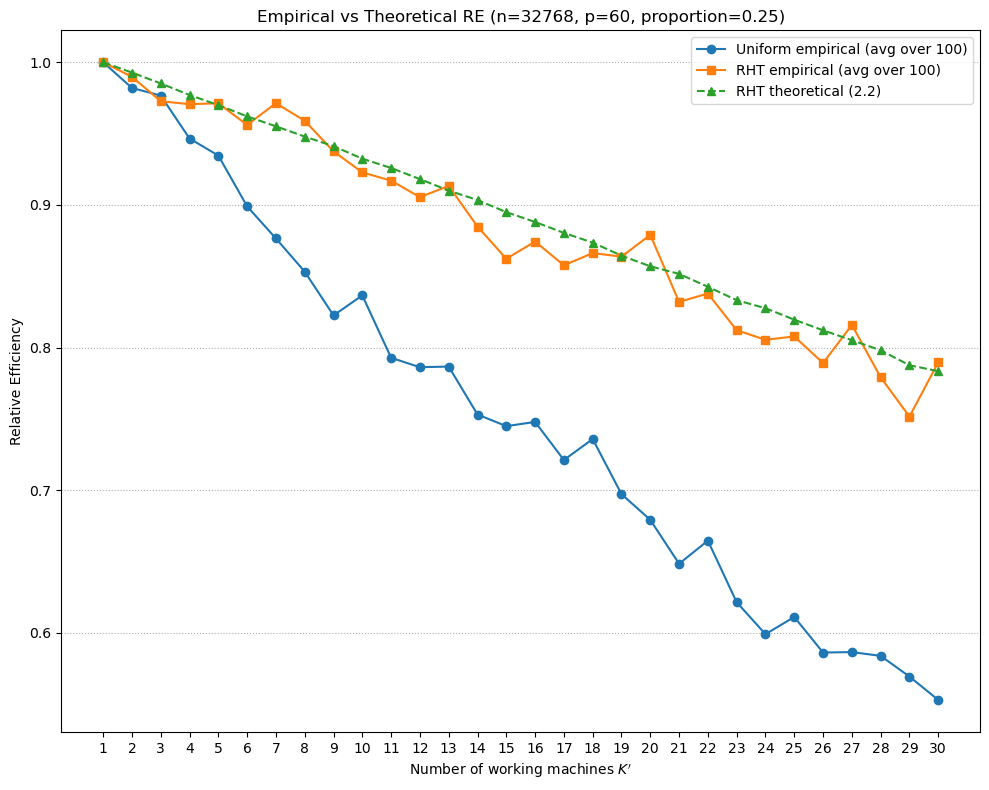

In [8]:
# === Experiment parameters ===
n = 8192 * 4      # total samples used inside algorithm_for_BHDdot
k = 16            # number of clients in algorithm_for_BHDdot
p = 60           # feature dimension

weight = 0.8
mu_1, mu_2 = 0, 5
var_1, var_2 = 1, 10
proportion = 0.25

K_prime_list = np.arange(1, 31)  # number of working machines
R = 30
base_seed = 39

RE_uniform_emp, RE_RHT_emp, RE_RHT_theory = run_empirical_vs_theoretical_BHDdot(
    n=n, k=k, p=p,
    weight=weight,
    mu_1=mu_1, mu_2=mu_2,
    var_1=var_1, var_2=var_2,
    proportion=proportion,
    K_prime_list=K_prime_list,
    R=R,
    base_seed=base_seed
)

# Convert dicts -> arrays for plotting
Ks = np.array(K_prime_list)
RE_uniform_vals = np.array([RE_uniform_emp[Kp] for Kp in Ks])
RE_RHT_emp_vals = np.array([RE_RHT_emp[Kp]     for Kp in Ks])
RE_RHT_th_vals  = np.array([RE_RHT_theory[Kp]  for Kp in Ks])

# === Plot: three lines on one graph ===
plt.figure(figsize=(10, 8))

plt.plot(Ks, RE_uniform_vals, marker='o', label='Uniform empirical (avg over 100)')
plt.plot(Ks, RE_RHT_emp_vals, marker='s', label='RHT empirical (avg over 100)')
plt.plot(Ks, RE_RHT_th_vals,  marker='^', linestyle='--', label='RHT theoretical (2.2)')

plt.xticks(Ks, Ks)
plt.xlabel(r'Number of working machines $K^\prime$')
plt.ylabel('Relative Efficiency')
plt.title(f'Empirical vs Theoretical RE (n={n}, p={p}, proportion={proportion})')
plt.grid(axis='y', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()
